In [1]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
import warnings
import itertools

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False 
matplotlib.rcParams['backend'] = 'SVG'

# 比特币预测参数的选择

In [3]:
df = pd.read_excel('E:/论文/论文2/数据/表.xlsx',index_col=0)
df.reset_index(inplace=True)
df.head()

,Date,USD (PM),Value,DealDay,黄金涨幅(%),比特币涨幅(%),黄金5日均价,黄金5日乖离率,比特币5日均价,比特币5日乖离率,...,黄金涨幅的前90日均值,黄金5日乖离率的前90日均值,黄金牛市,gold_cow,比特币涨幅的前30日均值,比特币5日乖离率的前30日均值,比特币牛市,bt_cow,黄金购买风险,比特币购买风险
0,2016-09-11,0.00,621.65,0,0.493311,0.641569,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.494444,-1,NaN,NaN,0.483333,-1,0.492608,0.485020
1,2016-09-12,1324.60,609.67,1,0.493311,0.609981,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.488889,-2,NaN,NaN,0.466667,-2,0.487354,0.468772
2,2016-09-13,1323.65,610.92,1,0.486412,0.644930,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.483333,-3,NaN,NaN,0.450000,-3,0.482100,0.452525
3,2016-09-14,1321.75,608.82,1,0.479503,0.635935,0.0,0.460623,0.000000,0.550392,...,NaN,NaN,0.477778,-4,NaN,NaN,0.433333,-4,0.476846,0.436278
4,2016-09-15,1310.80,610.38,1,0.413621,0.645769,0.0,0.460623,0.009834,0.545356,...,NaN,NaN,0.472222,-5,NaN,NaN,0.416667,-5,0.471592,0.419903


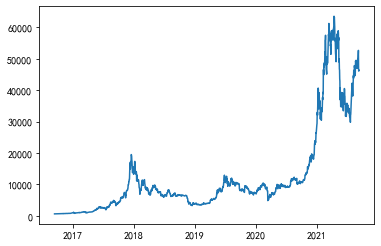

In [4]:
plt.plot(df['Date'][1:],df['Value'][1:])
#plt.savefig('比特币走势图.png')
plt.show()

In [5]:
#data = df['Value'][df['DealDay']==1].copy()
data = df['Value'][1:].copy()
data_diff=data
#data_diff.index=df['Date'][df['DealDay']==1].copy()
data_diff.index=df['Date'][1:].copy()
data_diff=data_diff.diff(1).dropna()
diff_df = pd.DataFrame()
diff_df['diff_1'] =  data_diff
diff_df['diff_2'] = data_diff.diff(1).dropna()
diff_df['diff_3'] = diff_df['diff_2'].diff(1).dropna()

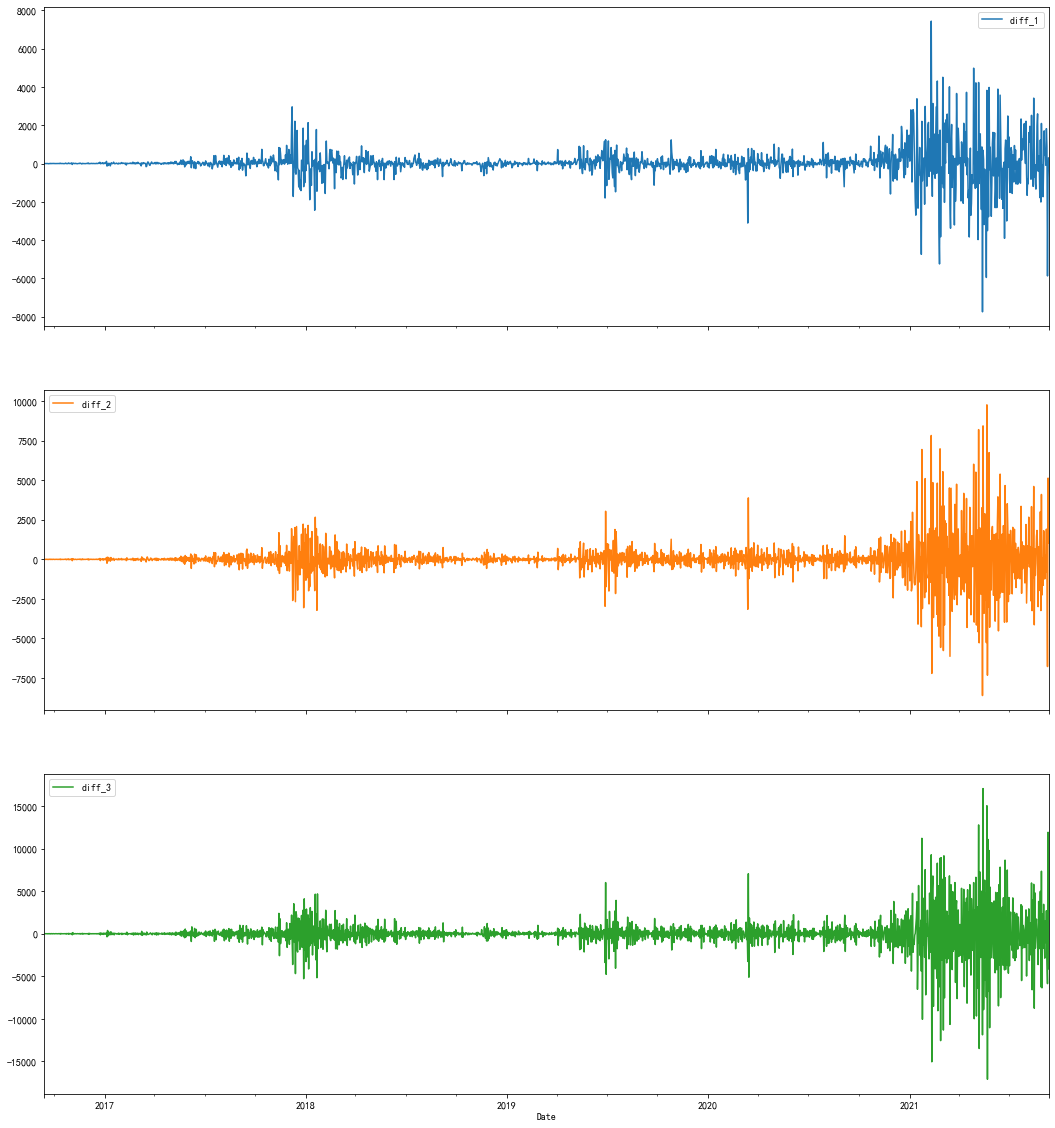

In [6]:
diff_df.plot(subplots=True,figsize=(18,20))
#plt.savefig('比特币差分对比图.png')
plt.show()
# 对比选择几阶差分,肉眼观察数据平稳性

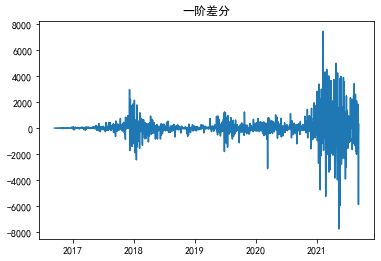

In [7]:
plt.plot(data_diff)
plt.title('一阶差分')
#plt.savefig('比特币一阶差分图.png')
plt.show()

adfuller单位根检验数据平稳性  
输出结果中：  
第一个是adt检验的结果，简称为T值，表示t统计量。  
第二个简称为p值，表示t统计量对应的概率值。  
第三个表示延迟。  
第四个表示测试的次数。  
第五个是配合第一个一起看的，是在99%，95%，90%置信区间下的临界的ADF检验的值。  

第一点，1%、5%、10%不同程度拒绝原假设的统计值和ADF Test result的比较，ADF Test result同时小于1%、5%、10%即说明非常好地拒绝该假设。  
第二点，p值要求小于给定的显著水平，p值要小于0.05，等于0是最好的。
ADF检验的原假设是存在单位根，只要这个统计值是小于1%水平下的数字就可以极显著的拒绝原假设，认为数据平稳。注意，ADF值一般是负的，也有正的，但是它只有小于1%水平下的才能认为是及其显著的拒绝原假设。  
（原假设为不是平稳时间序列)

In [8]:
print(adfuller(data))  # 原始数据
print(adfuller(diff_df['diff_1'].dropna()))  # 一阶差分
print(adfuller(diff_df['diff_2'].dropna()))  # 二阶差分
print(adfuller(diff_df['diff_3'].dropna()))  # 三阶差分

(-0.23815317208500575, 0.9338184137972233, 24, 1800, {'1%': -3.4339881389288407, '5%': -2.863147035877915, '10%': -2.567625533641975}, 29153.758728543813)
(-8.533026058412531, 1.025460247075281e-13, 23, 1800, {'1%': -3.4339881389288407, '5%': -2.863147035877915, '10%': -2.567625533641975}, 29136.63848121185)
(-15.718534002526605, 1.332655955328181e-28, 25, 1797, {'1%': -3.4339942213257535, '5%': -2.8631497209507284, '10%': -2.567626963361616}, 29172.063609888515)
(-17.140416166576706, 7.05111051772924e-30, 24, 1797, {'1%': -3.4339942213257535, '5%': -2.8631497209507284, '10%': -2.567626963361616}, 29389.538563939)


原始数据的P值>0.05所以不满足平稳性要求  
一阶差分的P值<0.05，且T值小于1%，5%，10%下的统计值，可以极显著的拒绝原假设，说明数据是平稳的。  
一阶差分数据已经平稳就无需继续做二阶差分了。  

In [9]:
acorr_ljungbox(data_diff, lags = 20)

(array([10.7793016 , 18.92387358, 19.70362879, 20.95671848, 20.97318022,
        21.88343951, 21.91239545, 31.23667711, 35.08316328, 43.98824669,
        45.0396765 , 63.90694831, 66.61681967, 69.87958677, 69.87962033,
        70.61928709, 71.05067502, 71.64558009, 78.07321049, 97.68717666]),
 array([1.02641402e-03, 7.77558484e-05, 1.95519634e-04, 3.22987872e-04,
        8.19565209e-04, 1.27118880e-03, 2.63026654e-03, 1.27506625e-04,
        5.76039357e-05, 3.30770427e-06, 4.77483653e-06, 4.33855998e-09,
        3.34734699e-09, 2.02946821e-09, 4.69314945e-09, 7.77162391e-09,
        1.42091652e-08, 2.37555777e-08, 3.98580985e-09, 3.25938061e-12]))

acorr_ljungbox输出结果的第二项为基于卡方分布的p统计量，一阶差分的P值都很小，所以该数据拒绝原假设，即认为该数据不是纯随机数据  
不是纯随机数才可以做时间序列分析

# 观察法选择p,q
|模型|ACF|PACF|
|-|-|-|
|AR(p)|衰减趋于零(几何型或振荡型)|p阶后截尾|
|MA(q)|q阶后截尾|衰减趋于零(几何型或振荡型)|
|ARMA(p,q)|q阶后衰减趋于零(几何型或振荡型)|p阶后衰减趋于零(几何型或振荡型)|

截尾:落在置信区间内( 95%的点都符合该规则)

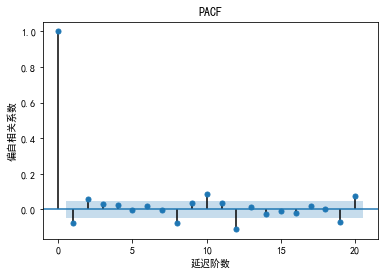

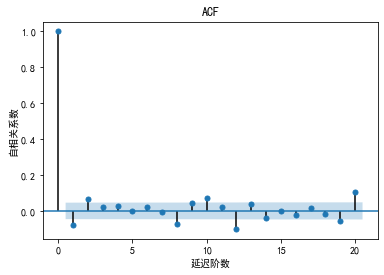

In [10]:
pacf = plot_pacf(data_diff, lags=20)
plt.xlabel("延迟阶数")
plt.ylabel("偏自相关系数")
plt.title('PACF')
plt.savefig('E:/论文/论文2/论文图片/图5比特币的PACF图.svg',format='svg')
pacf.show()

acf = plot_acf(data_diff, lags=20)
plt.xlabel("延迟阶数")
plt.ylabel("自相关系数")
plt.title('ACF')
plt.savefig('E:/论文/论文2/论文图片/图4比特币的ACF图.svg',format='svg')
acf.show()

# 穷举法选择最好的p,q
max_ar和max_ma为最大可取参数，数值较大时运行结果较长。建议为5

In [11]:
#import statsmodels.tsa.stattools as st
#model = st.arma_order_select_ic(data_diff, max_ar=20, max_ma=20, ic=['aic', 'bic', 'hqic'])
#model.bic_min_order 
# 结果为(p,q)

训练ARIMA模型  
order参数里的三个值分别为（p,d阶差分,q）  
对于使用穷举法得出结果为0,0,且绘制出的图形效果较差时，可以根据肉眼观察图主动选择

In [12]:
"""for p in [1,8,12]:
    for q in [1,8,12]:
        #model = ARIMA(data, order=(4,1,4))
        model = SARIMAX(data, order=(p,1,q))
        result = model.fit()
        resid = result.resid
        print('p:',p, '\tq:',q, '\taic:',result.aic, '\tbic:',result.bic,
             '\tDW:',sm.stats.durbin_watson(resid.values))"""

"for p in [1,8,12]:\n    for q in [1,8,12]:\n        #model = ARIMA(data, order=(4,1,4))\n        model = SARIMAX(data, order=(p,1,q))\n        result = model.fit()\n        resid = result.resid\n        print('p:',p, '\tq:',q, '\taic:',result.aic, '\tbic:',result.bic,\n             '\tDW:',sm.stats.durbin_watson(resid.values))"

In [13]:
#model = ARIMA(data, order=(12,1,12))
#result = model.fit()

In [14]:
model = SARIMAX(data, order=(12,1,12))
result = model.fit()

残差检验  
如果残差是白噪声序列，说明时间序列中有用的信息已经被提取完毕了，剩下的全是随机扰动，是无法预测和使用的。  
qq图中：如果是正态分布则为一条直线，即红线。结果大致符合白噪声

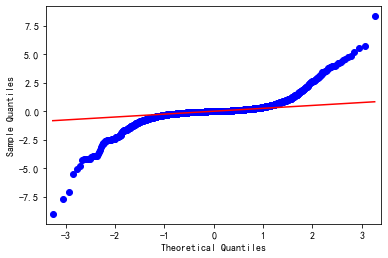

In [15]:
resid = result.resid

qqplot(resid, line='q', fit=True)
#plt.savefig('比特币arima残差QQ图.png')
plt.show()

Durbin-Watson 检验，又称 DW 检验，是用来检验回归分析中残差的一阶自相关性的(尤其针对时间序列数据)。  
该统计量值越接近 2 越好，一般在 1~3 之间说明没问题，小于 1 这说明残差存在自相关性

In [16]:
print(sm.stats.durbin_watson(resid.values))

2.0083930514036386


In [17]:
# result.summary()

预测  
predict(起始时间，终止时间)，预测出的结果为比特币的价格

In [18]:
pred = result.predict('2016-09-20','2021-9-10')
# pred = result.predict(1,1655)
print(len(pred))
print(pred[-10:])

1817
2021-09-01    47275.230430
2021-09-02    46696.378813
2021-09-03    49041.061812
2021-09-04    48955.726221
2021-09-05    50122.633193
2021-09-06    50001.535486
2021-09-07    51949.248347
2021-09-08    52750.863835
2021-09-09    47035.403498
2021-09-10    45917.977734
Freq: D, dtype: float64


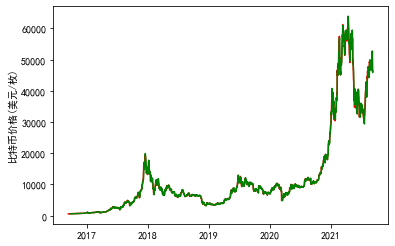

In [19]:
plt.plot(data,c='r')
plt.plot(pred,c='g')
plt.ylabel("比特币价格(美元/枚)")
plt.savefig('E:/论文/论文2/论文图片/图8比特币价格预测的结果.svg',format='svg')
plt.show()

虽然大幅涨势没有预测出来但是整体的峰值基本还是预测出来了。  
这里仅介绍了参数的选择，比特币同理，后续使用预测时不进行解释。这里预测结果仅为示意图，后续不需要使用，每一个使用的数据都是刚预测出来的。

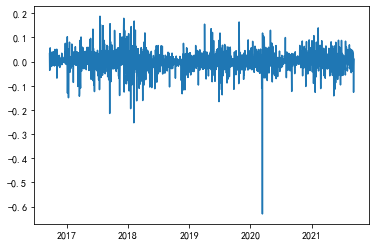

In [20]:
plt.plot((data-pred)/data)
#plt.savefig('E:/论文/论文2/论文图片/比特币价格相对误差图.svg',format='svg')
plt.show()